In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd

os.chdir(os.path.abspath('..'))


In [2]:
from omegaconf import OmegaConf
from dinov2.eval.setup import setup_logger
from dinov2.data.loaders import make_dataset

global logger
logger = setup_logger('dinov2', to_sysout=True, simple_prefix=True)

cfg = OmegaConf.load('notebooks/explore_crops.yaml')

ds_fmow = make_dataset(cfg.fmow.dataset, dino_augm_cfg=cfg.fmow.dino_augm, seed=42)
# ds_fmow_rgb = make_dataset(cfg.fmow_rgb.dataset, dino_augm_cfg=cfg.fmow_rgb.dino_augm, seed=42)
# ds_mmearth = make_dataset(cfg.mmearth.dataset, dino_augm_cfg=cfg.mmearth.dino_augm, seed=42)

/home/ando/PanOpticOn/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ando/PanOpticOn/dinov2/layers/attention.py:28: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ando/PanOpticOn/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


04:03:38 loaders.py:68] Building dataset "FmowDataset" ...
04:03:38 augmentations.py:291] ###################################
04:03:38 augmentations.py:292] Using data augmentation parameters:
04:03:38 augmentations.py:293] id: ChnSpatialAugmentationV2
04:03:38 augmentations.py:294] local_crops_number: 4
04:03:38 augmentations.py:295] global_crops_scale: [0.32, 1.0]
04:03:38 augmentations.py:296] local_crops_scale: [0.05, 0.32]
04:03:38 augmentations.py:297] global_crops_size: 224
04:03:38 augmentations.py:298] local_crops_size: 98
04:03:38 augmentations.py:299] global_crops_spectral_size: [6, 13]
04:03:38 augmentations.py:300] local_crops_spectral_size: [3, 6]
04:03:38 augmentations.py:301] global_modes_probs: [0.5, 0.3, 0.2]
04:03:38 augmentations.py:302] local_modes_probs: [0.2, 0.8]
04:03:38 augmentations.py:303] ###################################
04:03:38 augmentations.py:59] Augmentations in order: ['ChnSpatialAugmentationV2']
04:03:39 fmow.py:108] Using reference date: 2002-01-

In [3]:
from dinov2.models.panopticon import ChnAttnPatchEmb

patch_emb_cfg = {'patch_size': 14, 'embed_dim': 256}
chnAttnBlock_cfg = {'id_attn_block' :'ChnAttnBlockSimple', 'dim' : 256, 'num_heads':1}
chnEmb_cfg = {'embed_dim':256}

pan = ChnAttnPatchEmb(patch_emb_cfg=patch_emb_cfg, chnAttnBlock_cfg=chnAttnBlock_cfg, chnEmb_cfg=chnEmb_cfg) #, )

04:04:11 panopticon.py:28] ChnAttnPatchEmb: id_attn_block: ChnAttnBlockSimple
04:04:11 panopticon.py:104] ChnAttnBlockSimple: norm_input: True, skip_conn: True, norm_output: False, use_layer_scale: False


# FMOW

In [4]:
from torch.utils.data import DataLoader
import torch


dl_fmow = DataLoader(ds_fmow, batch_size=2)

sample = next(iter(dl_fmow))

sample = sample['global_crops_teacher'][0]
print(sample.keys())

input_0 = dict(imgs = sample['imgs'].to(dtype=torch.float32), chn_ids = sample['chn_ids'], spec_masks = sample['spec_masks'])

input_0['chn_ids'], input_0['spec_masks']

dict_keys(['imgs', 'chn_ids', 'spec_masks'])


(tensor([[[ 665.0317,   35.7759],
          [ 547.2723,   58.2955],
          [ 482.4178,   45.0297],
          [ 559.8556,   23.1510],
          [ 442.7530,   42.5272],
          [ 945.0536,   13.4182],
          [ 704.1148,    9.6195],
          [1373.4500,   20.0533],
          [ 664.6184,   20.7967],
          [ 492.7146,   42.5272],
          [ 864.7394,   14.4033],
          [1613.6824,   60.9985],
          [2202.3992,  115.9262]],
 
         [[ 665.0317,   35.7759],
          [ 547.2723,   58.2955],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297],
          [ 482.4178,   45.0297]]]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False]

In [5]:
input_0['imgs'].shape, input_0['chn_ids'].shape, input_0['imgs'].dtype, input_0['chn_ids'].dtype, input_0['chn_ids'].ndim

(torch.Size([2, 13, 224, 224]),
 torch.Size([2, 13, 2]),
 torch.float32,
 torch.float32,
 3)

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

for k in input_0:
    input_0[k] = input_0[k].to(device)
    torch.cuda.synchronize()

print(input_0['imgs'].device)

pan = pan.to(device)

print(next(pan.parameters()).device)

out = pan(input_0)
out[0].shape

cuda


cuda:0
cuda:0


torch.Size([2, 256, 256])

In [7]:
out[0]

tensor([[[ 0.1676,  0.0591, -0.2679,  ..., -0.0559, -0.2735, -0.2597],
         [ 0.2093,  0.0604, -0.2959,  ..., -0.0067, -0.3071, -0.2822],
         [ 0.1655,  0.0068, -0.2983,  ..., -0.0702, -0.2940, -0.2987],
         ...,
         [ 0.0209, -0.0807, -0.0016,  ..., -0.0198, -0.0382, -0.3102],
         [ 0.2016, -0.0173, -0.1999,  ..., -0.0569, -0.2119, -0.1968],
         [ 0.0685, -0.0284, -0.0984,  ..., -0.1707, -0.2481, -0.2343]],

        [[ 0.2714, -0.2637, -0.4503,  ...,  0.1052, -0.0192, -0.4206],
         [-0.0825,  0.1623, -0.5813,  ...,  0.0761, -0.4141, -0.1594],
         [ 0.1401, -0.0082, -0.4872,  ...,  0.0946, -0.2684, -0.4110],
         ...,
         [ 0.1732,  0.2671, -0.6665,  ...,  0.2388, -0.5738, -0.5373],
         [ 0.2971,  0.2599, -0.6750,  ...,  0.1099, -0.2886, -0.1716],
         [ 0.2156,  0.2702, -0.7520,  ...,  0.0608, -0.4418, -0.3473]]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [8]:
from tqdm.notebook import tqdm
max_iters = 100

for i in tqdm(range(max_iters)):
    sample = next(iter(dl_fmow))
    sample = sample['global_crops_teacher'][0]
    input_0 = dict(imgs = sample['imgs'].to(dtype=torch.float32), chn_ids = sample['chn_ids'], spec_masks = sample['spec_masks'])
    for k in input_0:
        input_0[k] = input_0[k].to(device)
        torch.cuda.synchronize()
    out = pan(input_0)
    # print(out[0].shape)


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
pan.chnemb.mu_map

{-1: 0,
 -2: 1,
 -3: 2,
 -4: 3,
 -5: 4,
 -6: 5,
 -7: 6,
 -8: 7,
 -9: 8,
 -10: 9,
 -11: 10,
 -12: 11,
 442: 12,
 482: 13,
 492: 14,
 547: 15,
 559: 16,
 664: 17,
 665: 18,
 704: 19,
 864: 20,
 945: 21,
 1373: 22,
 1613: 23,
 2202: 24,
 740: 25,
 782: 26,
 832: 27,
 427: 28,
 478: 29,
 545: 30,
 607: 31,
 658: 32,
 724: 33,
 949: 34}

# MMEARTH

## Optical only

In [10]:
from torch.utils.data import DataLoader
import torch


dl_mme = DataLoader(ds_mmearth, batch_size=2)

sample = next(iter(dl_mme))

sample = sample['global_crops_teacher'][0]
print(sample.keys())

input_0 = dict(imgs = sample['imgs'].to(dtype=torch.float32), chn_ids = sample['chn_ids'], spec_masks = sample['spec_masks'])

input_0['chn_ids'], input_0['spec_masks']

NameError: name 'ds_mmearth' is not defined

In [ ]:
input_0['imgs'].shape, input_0['chn_ids'].shape, input_0['imgs'].dtype, input_0['chn_ids'].dtype, input_0['chn_ids'].ndim

(torch.Size([2, 13, 196, 196]),
 torch.Size([2, 13, 2]),
 torch.float32,
 torch.float32,
 3)

In [ ]:
out = pan(input_0)
out[0].shape

torch.Size([2, 196, 256])

In [ ]:
pan.chnemb.mu_map

{-1: 0,
 -2: 1,
 -3: 2,
 -4: 3,
 -5: 4,
 -6: 5,
 -7: 6,
 -8: 7,
 -9: 8,
 -10: 9,
 -11: 10,
 -12: 11,
 442: 12,
 482: 13,
 492: 14,
 547: 15,
 559: 16,
 664: 17,
 665: 18,
 704: 19,
 740: 20,
 782: 21,
 832: 22,
 864: 23,
 945: 24,
 1373: 25,
 1613: 26,
 2202: 27}

## SAR

In [ ]:
from torch.utils.data import DataLoader
import torch


dl_mme = DataLoader(ds_mmearth, batch_size=2)

sample = next(iter(dl_mme))

sample = sample['global_crops_teacher'][1]
print(sample.keys())

input_1 = dict(imgs = sample['imgs'].to(dtype=torch.float32), chn_ids = sample['chn_ids'], spec_masks = sample['spec_masks'])

input_1['chn_ids'], input_1['spec_masks']

dict_keys(['imgs', 'chn_ids', 'spec_masks'])


(tensor([[[-10.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.],
          [ -9.,  -1.]],
 
         [[ -6.,  -1.],
          [ -9.,  -1.],
          [-10.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.],
          [ -5.,  -1.]]]),
 tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

In [ ]:
input_1['imgs'].shape, input_1['chn_ids'].shape, input_1['imgs'].dtype, input_1['chn_ids'].dtype, input_1['chn_ids'].ndim

(torch.Size([2, 13, 196, 196]),
 torch.Size([2, 13, 2]),
 torch.float32,
 torch.float32,
 3)

In [ ]:
out = pan(input_1)
out[0].shape

torch.Size([2, 196, 256])

In [13]:
pan.chnemb.mu_map

{-1: 0,
 -2: 1,
 -3: 2,
 -4: 3,
 -5: 4,
 -6: 5,
 -7: 6,
 -8: 7,
 -9: 8,
 -10: 9,
 -11: 10,
 -12: 11,
 442: 12,
 482: 13,
 492: 14,
 547: 15,
 559: 16,
 664: 17,
 665: 18,
 704: 19,
 864: 20,
 945: 21,
 1373: 22,
 1613: 23,
 2202: 24,
 740: 25,
 782: 26,
 832: 27,
 427: 28,
 478: 29,
 545: 30,
 607: 31,
 658: 32,
 724: 33,
 949: 34}

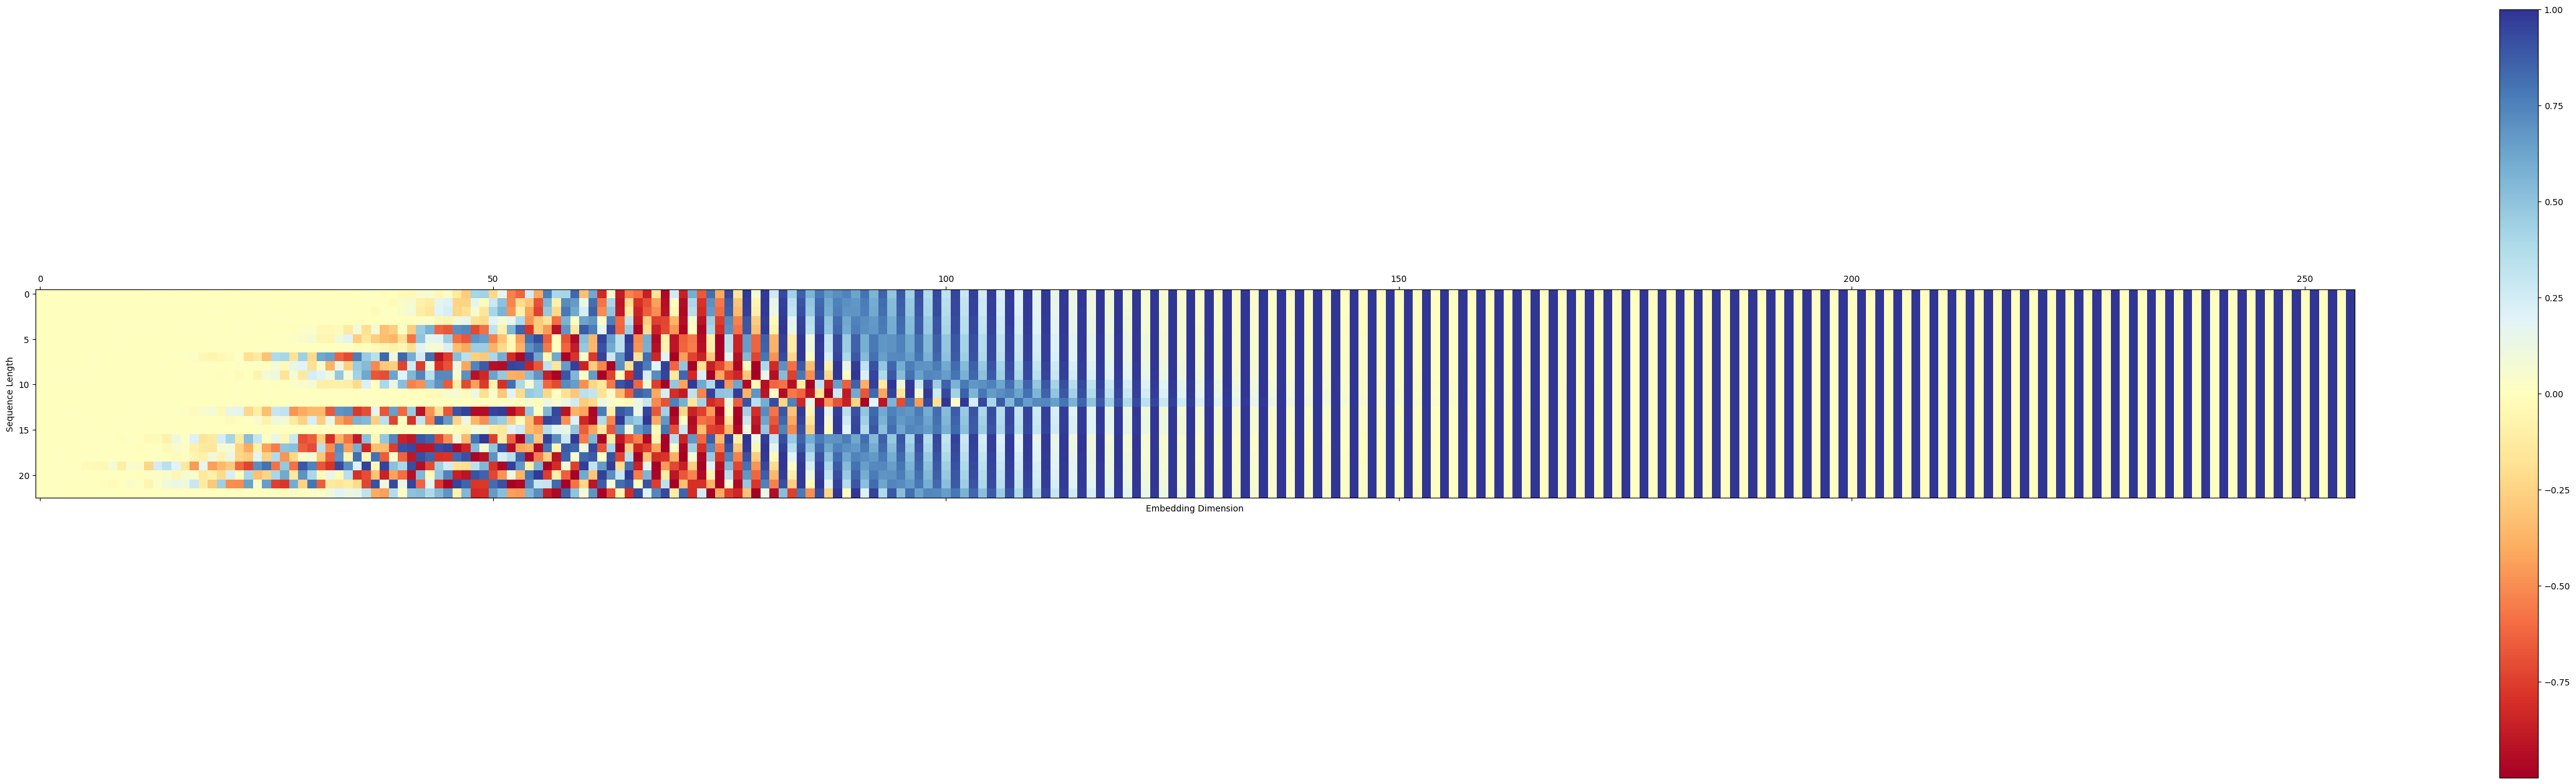

In [12]:
import matplotlib.pyplot as plt
IPE = pan.chnemb.cached_optical_embs.cpu().numpy()

fig, ax = plt.subplots(figsize=(60, 40))


#plot P using matshow in ax
cax = ax.matshow(IPE, cmap='RdYlBu')
fig.colorbar(cax, shrink=0.4)


ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Sequence Length')

plt.show()